# 先导入需要的包

In [65]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

- 读取一下数据看看
- 训练集有300000个样本

In [66]:
all_data = pd.read_csv(r"E:\Project\PyCharm\科大讯飞AI开发者大赛\糖尿病风险预测挑战赛\train.csv")
pre_data = pd.read_csv(r"E:\Project\PyCharm\科大讯飞AI开发者大赛\糖尿病风险预测挑战赛\test.csv")
print(all_data.shape)
print(pre_data.shape)

(300000, 23)
(100000, 22)


In [67]:
all_data['target'].value_counts()

0.0    252000
2.0     42000
1.0      6000
Name: target, dtype: int64

In [68]:
print(all_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])
print(pre_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

   id  HighBP  HighChol  CholCheck  Education    Income  target
0   0     0.0       0.0        1.0        6.0  8.000000     0.0
1   1     0.0       1.0        1.0        6.0  8.000000     0.0
2   2     0.0       0.0        1.0        4.0  6.512774     0.0
3   3     1.0       1.0        1.0        6.0  5.000000     2.0
       id  HighBP  HighChol  CholCheck        Age  Education   Income
0  300000     1.0       1.0        1.0   9.000000        6.0  8.00000
1  300001     1.0       1.0        1.0  12.285374        5.0  5.00000
2  300002     0.0       0.0        1.0   7.000000        6.0  8.00000
3  300003     0.0       0.0        1.0   5.000000        4.0  4.09852


In [69]:
print("训练集数据类型信息：")
print(all_data.dtypes)
print("验证集数据类型信息：")
print(pre_data.dtypes)

训练集数据类型信息：
id                        int64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
HeartDiseaseorAttack    float64
PhysActivity            float64
Fruits                  float64
Veggies                 float64
HvyAlcoholConsump       float64
AnyHealthcare           float64
NoDocbcCost             float64
GenHlth                 float64
MentHlth                float64
PhysHlth                float64
DiffWalk                float64
Sex                     float64
Age                     float64
Education               float64
Income                  float64
target                  float64
dtype: object
验证集数据类型信息：
id                        int64
HighBP                  float64
HighChol                float64
CholCheck               float64
BMI                     float64
Smoker                  float64
Stroke                  float64
Hear

In [70]:
print("是否包含字符串：")
print(all_data.dtypes.apply(lambda x: x.kind) == 'O')
print(pre_data.dtypes.apply(lambda x: x.kind) == 'O')

是否包含字符串：
id                      False
HighBP                  False
HighChol                False
CholCheck               False
BMI                     False
Smoker                  False
Stroke                  False
HeartDiseaseorAttack    False
PhysActivity            False
Fruits                  False
Veggies                 False
HvyAlcoholConsump       False
AnyHealthcare           False
NoDocbcCost             False
GenHlth                 False
MentHlth                False
PhysHlth                False
DiffWalk                False
Sex                     False
Age                     False
Education               False
Income                  False
target                  False
dtype: bool
id                      False
HighBP                  False
HighChol                False
CholCheck               False
BMI                     False
Smoker                  False
Stroke                  False
HeartDiseaseorAttack    False
PhysActivity            False
Fruits             

In [71]:
print("是否有缺失值：")
print(all_data.isna().sum())
print(pre_data.isna().sum())

是否有缺失值：
id                      0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
target                  0
dtype: int64
id                      0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth          

检查了数据并没有字符串和缺失值，所以可以先拿来训练一下，效果不好再做一些预处理。
获取特征和标签，并将其转化为torch的tensor

In [72]:
# 去掉标签id
all_features = all_data.iloc[:, 1:-1]
n_train = 25000 # 定义训练集大小

# 将测试和训练数据转换成tensor
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32, requires_grad=True, device=d2l.try_gpu())
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32, device=d2l.try_gpu())
train_labels = torch.tensor(
    all_data.iloc[:n_train, :].target.values.reshape(-1, 1), dtype=torch.long, device=d2l.try_gpu())
test_labels = torch.tensor(
    all_data.iloc[n_train:, :].target.values.reshape(-1, 1), dtype=torch.long, device=d2l.try_gpu())

#交叉熵损失要求目标标签只能是0或1维
train_labels = train_labels.reshape(train_labels.shape[0])
test_labels = test_labels.reshape(test_labels.shape[0])

# 获取输入特征的个数，也就是网络的输入大小
in_features = train_features.shape[1]
print(train_labels.shape, test_labels.shape)

torch.Size([25000]) torch.Size([275000])


# 将训练标签转换成one-hot编码，以便用来交叉熵损失
## 这里损失函数只要求输入类别即可不要求转换编码

In [73]:
# train_labels = train_labels.reshape(-1).long()
# train_labels = nn.functional.one_hot(train_labels, 3)
# test_labels = test_labels.reshape(-1).long()
# test_labels = nn.functional.one_hot(test_labels, 3)
# print(train_labels.shape, test_labels.shape)

# 现在开始构建网络模型
### 这里有个问题要注意，如果损失函数是CrossEntropyLoss，那网络的最后一层就不需要softmax层，CrossEntropyLoss包含了softmax操作和交叉熵

In [74]:
loss = nn.CrossEntropyLoss(reduction='none') # 交叉熵损失

net = nn.Sequential(
    nn.Linear(in_features, 32),
    nn.ReLU(),
    # 在第一个全连接层之后添加一个dropout层
    nn.Dropout(0.5),
    nn.Linear(32, 3),
)
net = net.to(device=d2l.try_gpu())

# 权重初始化
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights)

trainer = torch.optim.SGD(net.parameters(), lr=0.1, weight_decay=1)

print(len(net))

4


# 训练相关函数

In [75]:
def train_epoch_ch3(net, train_iter, loss, updater):
    # Set the model to training mode
    if isinstance(net, torch.nn.Module):
        net.train()
    # Sum of training loss, sum of training accuracy, no. of examples
    metric = d2l.Accumulator(3)
    for X, y in train_iter:
        # Compute gradients and update parameters
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # Using PyTorch in-built optimizer & loss criterion
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # Using custom built optimizer & loss criterion
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), d2l.accuracy(y_hat, y), y.numel())
    # Return training loss and training accuracy
    return metric[0] / metric[2], metric[1] / metric[2]

def train(net, train_iter, test_iter, loss, num_epochs, updater, show_img = False):

    if show_img == True:
        animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                            legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = d2l.evaluate_accuracy(net, test_iter)
        if show_img == True:
            animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    return train_loss

def select_lr(n):
    # 初始化最小训练损失和对应的学习率
    min_train_loss = float('inf')
    best_lr = None
    best_model_state_dict = None  # 保存最佳模型的参数

    # 使用torch的均匀分布生成随机学习率并找到最小训练损失的学习率
    # for i in range(n):
    n = 1
    for i in np.arange(0, 0.3, 0.001):
        # 从0到1的均匀分布中抽取一个随机数作为学习率
        lr = torch.distributions.uniform.Uniform(0, 0.3).sample().item()
        trainer.param_groups[0]['lr'] = i
        train_loss = train(net, train_iter, test_iter, loss, num_epochs, trainer) # 调用train函数获取训练损失
        print(f'第{n}次学习率为:{i}, loss为:{train_loss}')
        n += 1
        # 如果当前学习率的训练损失更小，则更新最小训练损失和对应的学习率
        if train_loss < min_train_loss:
            min_train_loss = train_loss
            best_lr = lr
            # 保存模型参数
            best_model_state_dict = net.state_dict()
    # 打印最小训练损失和对应的学习率
    print(f"最小训练损失：{min_train_loss}")
    print(f"对应的学习率：{best_lr}")

    return best_model_state_dict

0.590655365600586

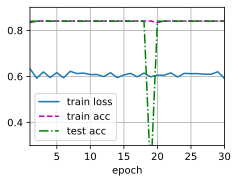

In [76]:
batch_size = 256
train_iter = d2l.load_array((train_features, train_labels), batch_size)
test_iter = d2l.load_array((test_features, test_labels), batch_size)
num_epochs = 30

train(net, train_iter, test_iter, loss, num_epochs, trainer, show_img = True)

# best_parm = select_lr(100)

# 现在将训练的结果对此测试集合进行预测，并写入文件进行提交

In [77]:
def pred(pred_features, pred_data):
    # 将网络应用于测试集。
    preds = net(pred_features).cpu().argmax(dim=1).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    pred_data['target'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([pred_data['id'], pred_data['target']], axis=1)
    print(submission['target'].value_counts())
    submission.to_csv(r"E:\Project\PyCharm\科大讯飞AI开发者大赛\糖尿病风险预测挑战赛\submission.csv", index=False)
    print('submission.csv is writed successfully!')

In [78]:
# net.load_state_dict(best_parm)
# pred_features = torch.tensor(pre_data.iloc[:, 1:].values, dtype=torch.float32, device=d2l.try_gpu())
# pred(pred_features, pre_data)